# Setup LLM - microsoft/Phi-3.5-mini-instruct

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


device = "cuda"
llm_model_name = "microsoft/Phi-3.5-mini-instruct" # Mục đích là đổi cho dễ

llm_model = AutoModelForCausalLM.from_pretrained(
  llm_model_name,
  torch_dtype=torch.bfloat16,
  device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(llm_model_name)


# Setup Text 2 Image - stabilityai/stable-diffusion-xl-base-1.0

In [ ]:
from diffusers import DiffusionPipeline
import torch

sd_model_name = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(
    sd_model_name,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16")

pipe.to(device)

# Crawl Nguoi dua tin -> array

In [3]:
import requests
from bs4 import BeautifulSoup

news_url = 'https://www.nguoiduatin.vn/da-chieu/ban-doc-viet.htm'

response = requests.get(news_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Tìm thẻ div lưu bài tin list__news-up cate
news_box_div  = soup.find("div", {"class": "list__news-up cate"})
news_items = news_box_div.find_all("div", {"class":"box-category-content"})

news_array = []

# Duyệt qua cấc bài tin
for item in news_items[:3]:
  title = item.find("a").text.strip()
  intro = item.find("p").text.strip()
  news_array.append(title + "\n" + intro)


In [4]:
news_array

['Cám ơn người đọc sách trong mưa\nTừ chuyện gặp một người đọc sách mà hy vọng cả phong trào đọc sách. Và nói luôn, cái bạn đọc sách này không phải diễn, bởi bạn ấy ngồi đọc rất lâu và chăm chú.',
 'Mùa Euro lại đến\nNhững ngày này, thông tin về mùa giải Euro 2024 tràn ngập trên các trang báo và mạng xã hội.',
 'Thế nào là đúng?\nCó thể, trong hành trình sống, ta có một vài sai lầm, nhưng đừng vì điều đó mà đánh mất cơ hội của cả một đời.']

# Generate prompt sinh ảnh cho các bài tin

In [7]:
news_prompt = []

for item in news_array:
  prompt = "Viết câu prompt bằng tiếng anh ngắn gọn bắt đầu bằng 'Create an illustration', không có tiếng việt trong prompt, để sinh ra ảnh minh hoạ bằng AI cho bài viết có nội dung sau đây:\n" + item
  messages = [
      {"role": "system", "content": "You are a helpfull assistant"},
      {"role": "user", "content": prompt}
  ]

  text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  model_inputs = tokenizer([text], return_tensors="pt").to(device)
  generated_ids = llm_model.generate(model_inputs.input_ids, max_new_tokens=200, do_sample=True, eos_token_id=tokenizer.eos_token_id)
  generated_ids = [
      output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

  response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
  news_prompt.append(response[0])

In [8]:
news_prompt

['Create an illustration depicting a serene scene of an individual deeply engrossed in reading a book amidst a gentle rain, embodying tranquility and the timeless joy of literary escape. The person, absorbed in pages, sits enveloped in warmth and solitude, as the raindrops accentuate the contemplative atmosphere. This AI-generated artwork aims to capture the essence of a quiet, communal appreciation for the written word, even as the world outside continues its rhythmic dance with the elements. Craft an AI-generated image that illustrates a peaceful tableau of a reader deeply immersed in a book under a softly falling rain, symbolizing the harmonious blend of solitude and community in the shared love for literature. The reader, comfortably nestled, is bathed in the cozy quietude, where each raindrop highlights',
 "Create an illustration depicting the buzz of Euro 2024 preparations in vibrant summer hues, capturing the public's excitement on various news platforms and social media.",
 "Cr

In [9]:
del llm_model
del tokenizer
import gc
gc.collect()

260

# Sinh ảnh từ prompt nói trên

In [10]:
images_list = []

for prompt in news_prompt:
  image = pipe(prompt).images[0]
  images_list.append(image)



Token indices sequence length is longer than the specified maximum sequence length for this model (162 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', communal appreciation for the written word, even as the world outside continues its rhythmic dance with the elements. craft an ai - generated image that illustrates a peaceful tableau of a reader deeply immersed in a book under a softly falling rain, symbolizing the harmonious blend of solitude and community in the shared love for literature. the reader, comfortably nestled, is bathed in the cozy quietude, where each raindrop highlights']
Token indices sequence length is longer than the specified maximum sequence length for this model (162 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["even errors shouldn 't cause us to lose our life's opportunities'ngắn gọn, bằng tiếng anh, được kế thẩm theo cơ chế của việc bố trí giá trị đáng khách trong hành trình sống, yêu cầu ảnh ai minh hoạ cho rước cảm hứng chân th"]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["even errors shouldn 't cause us to lose our life's opportunities'ngắn gọn, bằng tiếng anh, được kế thẩm theo cơ chế của việc bố trí giá trị đáng khách trong hành trình sống, yêu cầu ảnh ai minh hoạ cho rước cảm hứng chân th"]


  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
images_list

[<PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>]

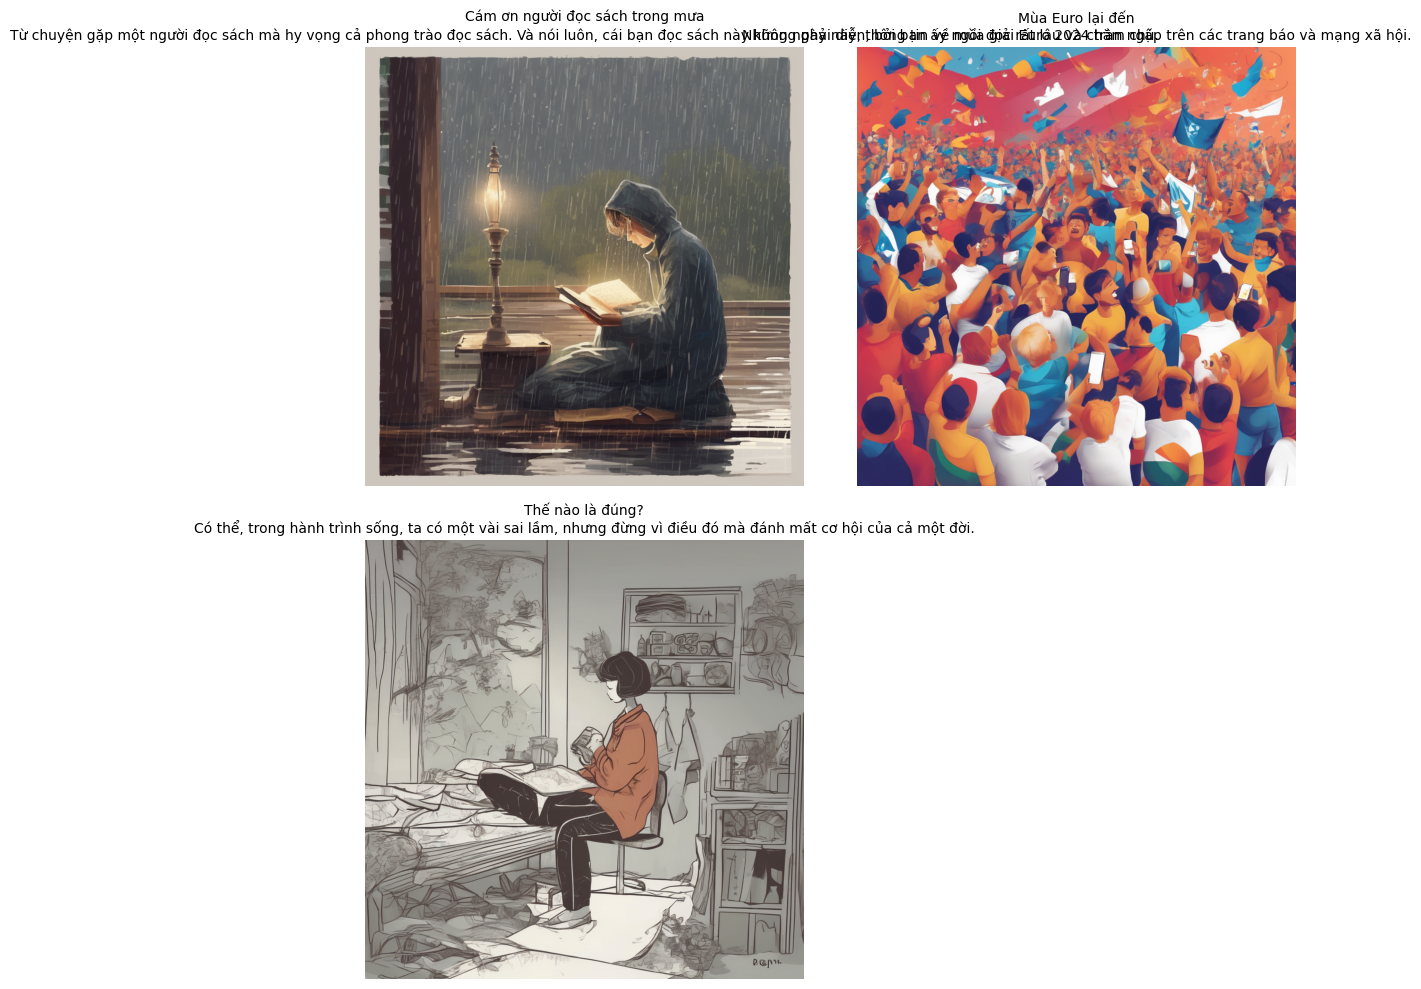

In [12]:
import matplotlib.pyplot as plt


# Kiểm tra số lượng ảnh và caption
assert len(images_list) == len(news_array), "Number of images and captions must be the same!"

# Số hàng và cột của grid
rows, cols = 2, 2

# Kích thước figure
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Hiển thị ảnh và caption
for i, ax in enumerate(axes.flat):
    if i < len(images_list):  # Đảm bảo index không vượt quá danh sách ảnh
        ax.imshow(images_list[i])
        ax.set_title(news_array[i], fontsize=10)
        ax.axis('off')  # Ẩn các trục
    else:
        ax.axis('off')  # Ẩn ô thừa

# Tăng khoảng cách giữa các subplots
plt.tight_layout()
plt.show()